## Chiptune Generation Project Timing

Notebook for measuring executing time of various MCC functionality.

In [1]:
from modules import mcc_parser, mcc_markov, mcc_waves, mcc_builder

import matplotlib.pyplot as plt
import numpy as np
import time
import os
%matplotlib inline

sr = 44100

In [2]:
# Average time to generate first track of each song for k=? .
songs = list(os.walk("./data"))[0][2]

def measure_markov(k:int, nsamples:int, wavefn) -> tuple:
    global songs
    avg_fit_times = []
    avg_pred_times = []
    avg_wavegen_times = []
    
    for song in songs:
        mid = mcc_parser.open_midi(f"./data/{song}")
        info = mcc_parser.extract_midi_info(mid.tracks[0])
        tracks = mcc_parser.extract_midi_tracks(mid.tracks)
        track = mcc_parser.midi_to_rtttl(tracks[0], mid.ticks_per_beat)

        mm = mcc_markov.KMarkov(k)
        
        try:
            t0 = time.time()
            mm.fit(track)
            t1 = time.time()
            avg_fit_times.append(t1-t0)
            
            t0 = time.time()
            gen = mm.predict(samples=nsamples)
            t1 = time.time()
            avg_pred_times.append(t1-t0)
            
            t0 = time.time()
            res = mcc_waves.notes_to_waveform(gen, bpm=info["tempo"][0], wave_function=wavefn)
            t1 = time.time()
            avg_wavegen_times.append(t1-t0)

        except:
            # Anomalies usually occur when the track is shorter than the specified k value.
            print(" anomaly!!")
            avg_fit_times.append(np.mean(avg_fit_times))
            avg_pred_times.append(np.mean(avg_pred_times))
            avg_wavegen_times.append(np.mean(avg_wavegen_times))

    return np.mean(avg_fit_times), np.mean(avg_pred_times), np.mean(avg_wavegen_times)

k=1 : fit:0.00016987323760986328 pred:0.0006254673004150391 gen:0.03237431049346924
k=4 : fit:0.00021357536315917968 pred:0.0006644248962402344 gen:0.038572049140930174
k=7 : fit:0.00023365020751953125 pred:0.0007603883743286133 gen:0.04150657653808594
k=10 : fit:0.00024480819702148436 pred:0.0006403684616088867 gen:0.04601633548736572
k=13 : fit:0.00027253627777099607 pred:0.000781106948852539 gen:0.04628491401672363
k=16 : fit:0.0002660274505615234 pred:0.0006357908248901367 gen:0.05132217407226562
k=19 : fit:0.0002849102020263672 pred:0.0010278463363647462 gen:0.058642792701721194
k=22 : fit:0.00030014514923095705 pred:0.0007179737091064453 gen:0.06520531177520753
k=25 : fit:0.0003215789794921875 pred:0.0008689641952514648 gen:0.07146506309509278
k=28 : fit:0.00030775070190429686 pred:0.0009701728820800781 gen:0.07409789562225341
k=31 : fit:0.0003123760223388672 pred:0.0009649276733398437 gen:0.07552509307861328
k=34 : fit:0.00032401084899902344 pred:0.0010295629501342774 gen:0.0832

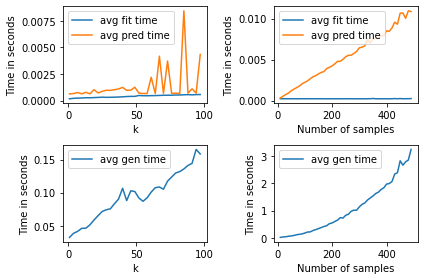

In [3]:
fig, axs = plt.subplots(2,2)

def plot(plt_i:int, mode:bool, start:int, stop:int, step:int, nsamples:int=50, k:int=1):
    global fig, axs
    xs = []
    avg_fit_time = []
    avg_pred_time = []
    avg_wavegen_time = []
    
    for i in range(start, stop, step):
        if mode:
            # Specify k. Fixed number of samples.
            ft, pt, wgt = measure_markov(i, nsamples, mcc_waves.triangle_wave)
            print(f"k={i} : fit:{ft} pred:{pt} gen:{wgt}")
        else:
            # Specify samples. Fixed k.
            ft, pt, wgt = measure_markov(k, i, mcc_waves.triangle_wave)
            print(f"nsamples={i} : fit:{ft} pred:{pt} gen:{wgt}")

        xs.append(i)
        avg_fit_time.append(ft)
        avg_pred_time.append(pt)
        avg_wavegen_time.append(wgt)
        
    axs[0,plt_i].plot(xs, avg_fit_time)
    axs[0,plt_i].plot(xs, avg_pred_time)
    if mode:
        axs[0,plt_i].set_xlabel("k")
    else:
        axs[0,plt_i].set_xlabel("Number of samples")  
    axs[0,plt_i].set_ylabel("Time in seconds")
    axs[0,plt_i].legend(["avg fit time", "avg pred time"])

    axs[1,plt_i].plot(xs, avg_wavegen_time)
    if mode:
        axs[1,plt_i].set_xlabel("k")
    else:
        axs[1,plt_i].set_xlabel("Number of samples")
    axs[1,plt_i].set_ylabel("Time in seconds")
    axs[1,plt_i].legend(["avg gen time"])
    
        

# Check effect of k. Fixed samples at 25.
plot(0, True, 1, 100, 3, nsamples=25)

# Check effect of number of samples. Fixed k at 5.
plot(1, False, 10, 500, 10, k=5)

fig.tight_layout()
plt.show()